In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import resize as Resize
from msdlib import mlutils, msd
from IPython.core.display import HTML
import os
import time
from PIL import Image

C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\abdul\Anaconda3\envs\torchenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns = None

In [3]:
data_dir = 'E:\\Data sets\\MNIST'
gen_input_size = 128
batch_size = 128
epoch = 50
learning_rate = .0001
K = 1
gen_step = 2
gen_gamma = .9
disc_step = 2
disc_gamma = .9
sample_interval = 300
device = 'cuda'
image_dim = 32
gen_input_channel = 64

In [4]:
data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [5]:
dimension = int((data.shape[1] - 1)**.5)
if torch.cuda.is_available() and device == 'cuda':
    device = 'cuda'
else:
    device= ' cpu'

In [6]:
label = data['label'].values.copy()
data.drop('label', axis=1, inplace=True)
ydim = np.unique(label).shape[0]

In [7]:
data = torch.tensor(data.values, device=device).view(-1, 1, dimension, dimension)
data = Resize(data, image_dim)
data = ((data / 255) - .5) * 2
data.shape

torch.Size([42000, 1, 32, 32])

2


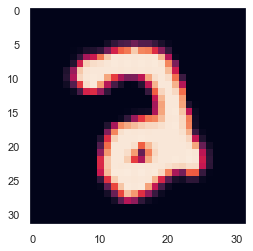

3


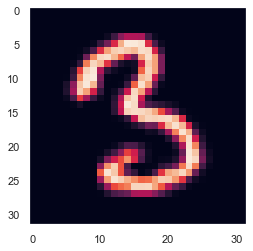

8


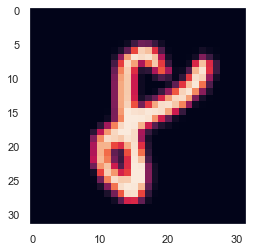

2


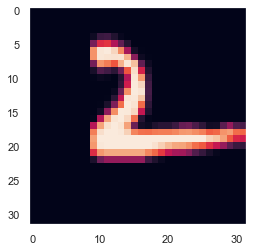

5


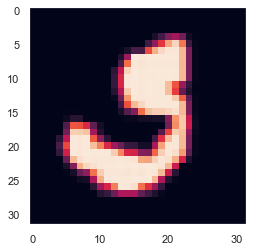

3


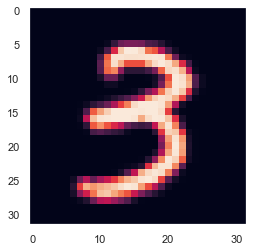

7


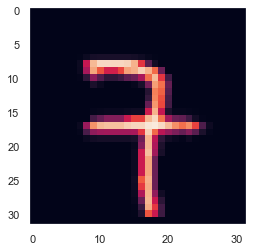

5


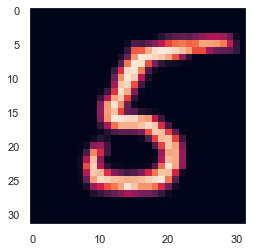

2


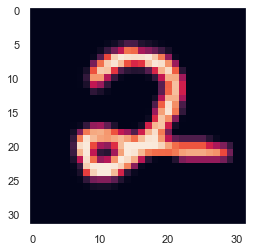

5


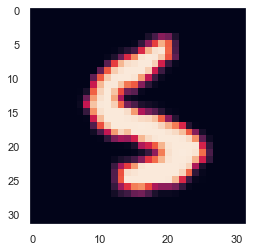

In [8]:
for i in range(10):
    i = np.random.randint(data.shape[0])
    print(label[i])
    plt.Figure()
    plt.imshow(data[i, 0].cpu())
    plt.grid(False)
    plt.show()

In [11]:
class Generator(torch.nn.Module):
    
    def __init__(self, input_dim=256, image_dim=32, input_channel=64, ydim=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.image_dim = image_dim
        self.input_channel = input_channel
        self.input_img_dim = image_dim // 4
        self.ydim = ydim
        
        self.define_model()
        
    def define_model(self):
        
        self.linear_model = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim + self.ydim, self.input_channel * (self.input_img_dim ** 2)),
            torch.nn.BatchNorm1d(self.input_channel * (self.input_img_dim ** 2)),
            torch.nn.LeakyReLU(negative_slope=.2)
        )
        self.conv_model = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(self.input_channel, 64, 3, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(negative_slope=.2),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(64, 64, 3, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(negative_slope=.2),
            torch.nn.Conv2d(64, 3, 5, padding='same'),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        x = self.linear_model(x)
        x = x.view(-1, self.input_channel, self.input_img_dim, self.input_img_dim)
        x = self.conv_model(x)
        return x

In [12]:
class Discriminator(torch.nn.Module):
    
    def __init__(self, batch_size=128, image_dim=32, ydim=10):
        super(Discriminator, self).__init__()
        self.batch_size = batch_size
        self.image_dim = image_dim
        self.ydim = ydim
        
        self.define_model()
        
    def define_model(self):
        self.conv_model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 5, padding='same'),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(negative_slope=.2),
            torch.nn.Conv2d(64, 8, 3, padding='same'),
            torch.nn.LeakyReLU(negative_slope=.2)
        )
        self.y_model = torch.nn.Sequential(
            torch.nn.Linear(self.ydim, self.ydim),
            torch.nn.BatchNorm1d(self.ydim),
            torch.nn.LeakyReLU(negative_slope=.2)
        )
        self.linear_model = torch.nn.Sequential(
            torch.nn.Linear((self.image_dim**2) * 8 + self.ydim, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x, y):
        x = self.conv_model(x)
        x = x.view(-1, (self.image_dim**2) * 8)
        y = self.y_model(y)
        x = torch.cat([x, y], axis=1)
        x = self.linear_model(x)
        return x

In [13]:
def rgb2gray(x):
    return .299 * x[:, [0], :, :] + .587 * x[:, [1], :, :] + .114 * x[:, [2], :, :]

class DataSet(torch.utils.data.Dataset):
    """
    This is a customized Data set object which can build a torch.utils.data.Dataset object given the data and labels. 
    This is only usable when we have complete data and labels (data and label lengths must be equal)

    Inputs:
        :data: ideally should be numpy ndarray, pandas DataFrame or torch tensor. Contains feature data tor model training.
               Can be python list or python set too but not much appreciated as it will be mostly used for training pytorch model.
        :label: ideally should be numpy ndarray, pandas Series/DataFrame or torch tensor. Contains true labels tor model training.
                Can be python list or python set too but not much appreciated as it will be mostly used for training pytorch model.
    """

    def __init__(self, data, label):
        self.data = data
        self.label = label
        if self.label is not None:
            self._check_samples()
        self.datalen = data.shape[0]
        
    def __len__(self):
        return self.datalen
    
    def __getitem__(self, index):
        label = self.label[index] if self.label is not None else None
        return self.data[index], label
    
    def _check_samples(self):
        assert len(self.data) == len(self.label), "Data and Label lengths are not same"

In [14]:
class GANTrainer():
    
    def __init__(self, K=1, image_dim=10, ydim=10, gen_input_channel=64, gen_input_size=128, learning_rate=.0001, epoch=100, batch_size=64, 
                 gen_step=1, gen_gamma=1, disc_step=1, disc_gamma=1, sample_intv=500, device='cuda', dtype=torch.float32):
        
        self.K_rev = np.ceil(1/K)
        self.K = np.ceil(K)
        self.image_dim = image_dim
        self.ydim = ydim
        self.gen_input_channel = gen_input_channel
        self.gen_input_size = gen_input_size
        self.lr = learning_rate
        self.epoch = epoch
        self.batch_size = batch_size
        self.dtype = dtype
        self.device = device
        self.gen_step = gen_step
        self.gen_gamma = gen_gamma
        self.disc_step = disc_step
        self.disc_gamma = disc_gamma
        self.sample_intv = sample_intv
        
        self.gen = Generator(input_dim=self.gen_input_size, image_dim=self.image_dim, ydim=self.ydim,
                             input_channel=self.gen_input_channel).to(device=self.device, dtype=self.dtype)
        self.disc = Discriminator(batch_size=self.batch_size, image_dim=self.image_dim, ydim=self.ydim).to(device=self.device, dtype=self.dtype)
        
        self.set_optimizer()
    
    def set_optimizer(self):
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr=self.lr, betas=(.5, .999))
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), lr=self.lr, betas=(.5, .999))
        self.gen_sch = torch.optim.lr_scheduler.StepLR(self.gen_opt, self.gen_step, self.gen_gamma, verbose=False)
        self.disc_sch = torch.optim.lr_scheduler.StepLR(self.disc_opt, self.disc_step, self.disc_gamma, verbose=False)
        
    def train(self, data, label):
        label = msd.one_hot_encoding(label, class_label=list(range(self.ydim)))
        label = torch.tensor(label, device=self.device, dtype=self.dtype)
        data = data.to(device=self.device, dtype=self.dtype)
        data_loader = torch.utils.data.DataLoader(DataSet(data, label), batch_size=self.batch_size, shuffle=True)
        
        self.losses = {'gen': [], 'disc': []}
        k = 0
        
        self.total_batch = len(data_loader)
        t1 = time.time()
        cnt = 0
        for ep in range(self.epoch):
            _genloss = []
            _discloss = []
            gen_loss = 0
            
            gendata = np.random.random(size=(data.shape[0], self.gen_input_size))
            gendata = torch.tensor(gendata, device=self.device, dtype=self.dtype).squeeze()
            gen_loader = torch.utils.data.DataLoader(gendata, batch_size=self.batch_size, shuffle=True)
            
            for i, (batch_gendata, (batch_data, batch_label)) in enumerate(zip(gen_loader, data_loader)):
                self.gen.train()
                self.disc.train()
                
                gen_batch = torch.cat([batch_gendata, batch_label], axis=1)
                if k % self.K_rev == 0:
                    # discriminator loss
                    self.disc.zero_grad()
                    g_out = self.gen(gen_batch).detach()
                    d_data = self.disc(batch_data, batch_label)
                    g_out = rgb2gray(g_out)
                    d_g = self.disc(g_out, batch_label)

                    disc_loss = - torch.mean(torch.log(d_data) + torch.log(1 - d_g))
                    _discloss.append(disc_loss.item())
                    disc_loss.backward()
                    self.disc_opt.step()
                
                if k % self.K == 0:
                    # generator loss
                    self.gen.zero_grad()
                    g_out = self.gen(gen_batch)
                    g_out = rgb2gray(g_out)
                    d_g = self.disc(g_out, batch_label)

                    gen_loss = torch.mean(torch.log(1 - d_g))
                    _genloss.append(gen_loss.item())
                    gen_loss.backward()
                    self.gen_opt.step()
                
                if cnt % self.sample_intv == 0:
                    self.save_sample(ep, i)
                k += 1
                cnt += 1
                
                time_string = msd.get_time_estimation(time_st=t1, current_ep=ep, current_batch=i, total_ep=self.epoch, total_batch=self.total_batch)
                print('\repoch : %04d/%04d, batch : %03d, generator_loss : %.4f, discriminator_loss : %.4f,  %s'
                      % (ep + 1, self.epoch, i + 1, gen_loss, disc_loss, time_string)+' '*20, end='', flush=True)
            
                self.losses['gen'].append(gen_loss.item())
                self.losses['disc'].append(disc_loss.item())
            self.gen_sch.step()
            self.disc_sch.step()
    
    def generate(self, label):
        self.gen.eval()
        label = msd.one_hot_encoding(label, class_label=list(range(self.ydim)))
        label = torch.tensor(label, device=self.device, dtype=self.dtype)
        gendata = np.random.random(size=(len(label), self.gen_input_size))
        gendata =  torch.tensor(gendata, device=self.device, dtype=self.dtype).squeeze()
        gendata = torch.cat([gendata, label], axis=1)
        g_out = self.gen(gendata).squeeze()
        g_out = ((g_out / 2) + .5) * 255
        
        return g_out
    
    def plot_learning_curve(self):
        losses = pd.DataFrame(self.losses, index=np.arange(len(self.losses['gen'])) / self.total_batch)
        same_srs = [losses[c] for c in losses.columns]
        msd.plot_time_series(same_srs=same_srs, show=True, segs=1)
    
    def save_sample(self, ep, batch):
        os.makedirs('samples-CDCGAN', exist_ok=True)
        label = np.arange(100) % 10
        out = self.generate(label).permute(0, 2, 3, 1)
        A = [[] for _ in range(10)]
        for i in range(10):
            for j in range(10):
                A[i].append(out[i*10+j].detach().cpu().numpy().astype(np.uint8))
            A[i] = np.concatenate(A[i], axis=1)
        A = np.concatenate(A, axis=0)
        plt.imsave("samples-CDCGAN/epoch-%d_batch-%d.jpg"%(ep, batch), A, cmap='hot')


In [15]:
trainer = GANTrainer(K=K, image_dim=image_dim, ydim=ydim, gen_input_channel=gen_input_channel, gen_input_size=gen_input_size, learning_rate=learning_rate, epoch=epoch, batch_size=batch_size,
                     gen_step=gen_step, gen_gamma=gen_gamma, disc_step=disc_step, disc_gamma=disc_gamma, sample_intv=sample_interval, device=device)

epoch : 0050/0050, batch : 329, generator_loss : -0.1269, discriminator_loss : 0.2304,  2:19:46 < 0:00:00                     

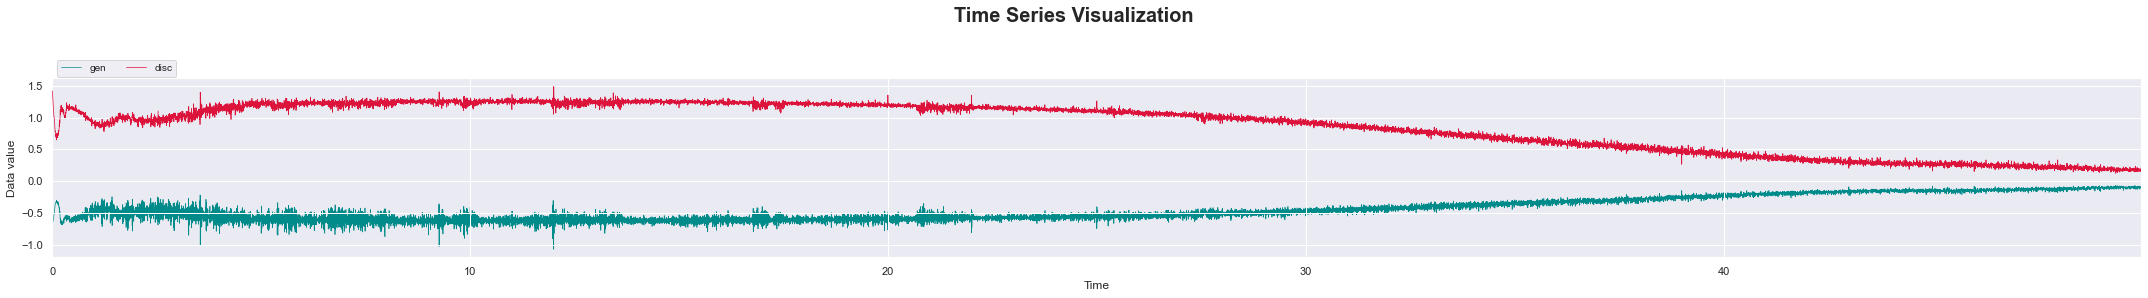

In [16]:
try:
    trainer.train(data, label)
    trainer.plot_learning_curve()
except KeyboardInterrupt:
    trainer.plot_learning_curve()

In [24]:
zc = [0, 9]
out = trainer.generate(zc).permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.uint8)

1


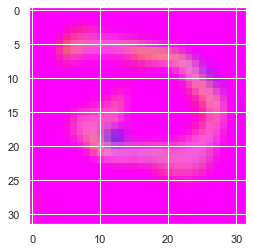

0


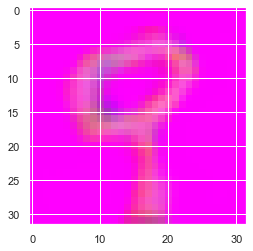

In [25]:
for i in range(len(out)):
    print(label[i])
    plt.Figure()
    plt.imshow(out[i])
    plt.show()